# Bayesian Radial Velocity Planet Search

One area in astronomy where Bayesian approaches have been applied with great success is in the hunt for extrasolar planets.
There are several benefits of Bayesian modeling in this situation. In particular:

1. Bayesian modeling can account for the many nuisance parameters typical in a planet search. For example, when seeking evidence of a planet around a star, we need our model to account for things like the phase and the longitude of periastron, but we don't necessarily care about these parameters in the end.

2. Often we have very important prior information – for example, we might have a very good constraint on the period from eclipse data, and use this to model orbital parameters with radial velocity data.

3. The forward-modeling aspect of Bayesian approaches can be advantageous when dealing with detectors that have strong systematic uncertainties. For example, this idea is key to some of the recent analysis of K2 data.

Here we'll take a look at a Bayesian approach to determining orbital parameters of a planet from radial velocity (RV) measurements.
We'll start with some generated data in which we know the correct answer, and then take a look at some real RV measurements from the literature.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set()

### The Radial Velocity Model

The first important step is to define a mathematical (and computational) model of how the parameters of interest are reflected in our observations.

Some references relating to what we're going to compute below:

- Balan 2009: http://adsabs.harvard.edu/abs/2009MNRAS.394.1936B
- Exofit Manual: http://www.star.ucl.ac.uk/~lahav/ExoFitv2.pdf
- Hou 2014: http://arxiv.org/pdf/1401.6128.pdf

The equation for radial velocity is this:

$$
v(t) = V - K[ \sin(f + \omega) + e \sin(\omega)]
$$

where $V$ is the overall velocity of the system, and

$$
K = \frac{m_p}{m_s + m_p} \frac{2\pi}{T}\frac{a \sin i}{\sqrt{1 - e^2}}
$$

The true anomaly $f$ satisfies

$$
\cos(f) = \frac{\cos(E) - e}{1 - e\cos E}
$$

Rearranging this we can write
$$
f = 2 \cdot{\rm atan2}\left(\sqrt{1 + e}\sin(E/2), \sqrt{1 - e} \cos(E/2)\right)
$$

The eccentric anomaly $E$ satisfies
$$
M = E - e\sin E
$$

and the mean anomaly is
$$
M = \frac{2\pi}{T}(t + \tau)
$$

and $\tau$ is the time of pericenter passage, which we'll parametrize with the parameter $\chi = \tau /  T$

These are the parameters needed to compute the radial velocity:

- $T$: orbital period
- $K$: amplitude of RV oscillation
- $V$: secular offset of RV oscillation
- $e$: eccentricity
- $\omega$: longitude of periastron
- $\chi$: dimensionless phase offset

Additionally, we will fit a scatter parameter $s$ which accounts for global data errors not reflected in the reported uncertainties (this is very similar to the third parameter from the linear fit we saw earlier)

For convenience, we'll store these parameters in a ``namedtuple``:

In [2]:
from collections import namedtuple
params = namedtuple('params', ['T', 'e', 'K', 'V', 'omega', 'chi', 's'])

Here is a function to compute the observed radial velocity as a function of these parameters:

In [3]:
from scipy import optimize

@np.vectorize
def compute_E(M, e):
    """Solve Kepler's eqns for eccentric anomaly given mean anomaly"""
    f = lambda E, M=M, e=e: E - e * np.sin(E) - M
    return optimize.brentq(f, 0, 2 * np.pi)


def radial_velocity(t, theta):
    """Compute radial velocity given orbital parameters"""
    T, e, K, V, omega, chi = theta[:6]
    
    # compute mean anomaly (0 <= M < 2pi)
    M = 2 * np.pi * ((t / T + chi) % 1)
    
    # solve for eccentric anomaly
    E = compute_E(M, e)
    
    # compute true anomaly
    f = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2),
                       np.sqrt(1 - e) * np.cos(E / 2))
    
    # compute radial velocity
    return V - K * (np.sin(f + omega) + e * np.sin(omega))

Just to get a sense of whether we've done this correctly, let's use IPython's interactive features to see how the parameters change the observed RV curve (you may have to first ``pip install ipywidgets``)

In [4]:
from ipywidgets import interact

def plot_RV(T, e, K, V, omega, chi):
    t = np.linspace(0, 5, 200)
    theta = [T, e, K, V, omega, chi]
    plt.plot(t, radial_velocity(t, theta))
    
interact(plot_RV,
         T=(0, 5.), K=(0, 2000.), V=(-2000., 2000.),
         e=(0, 1.), omega=(0, 2 * np.pi), chi=(0, 1.));

interactive(children=(FloatSlider(value=2.5, description='T', max=5.0), FloatSlider(value=0.5, description='e'…

The model seems to be working as expected!

### Fitting Simulated Data

Now let's generate some simulated data so that we can explore a Bayesian approach to modeling the radial velocity effects of a planet orbiting a star.
We'll choose some reasonable parameters and create some data:

In [5]:
theta_sim = params(T=700, e=0.38, K=60, V=12,
                   omega=3.10, chi=0.67, s=1)
Nobs = 50

rng = np.random.RandomState(0)
t_sim = 1400 + 600 * rng.rand(Nobs)
err_sim = 5 + 5 * rng.rand(Nobs)
rv_sim = radial_velocity(t_sim, theta_sim) + err_sim * rng.randn(Nobs)

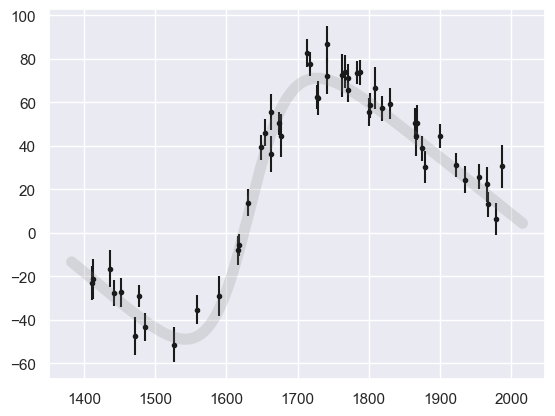

In [6]:
plt.errorbar(t_sim, rv_sim, err_sim, fmt='.k');
xlim = plt.xlim()
t_fit = np.linspace(xlim[0], xlim[1], 500)
plt.plot(t_fit, radial_velocity(t_fit, theta_sim), color='gray', lw=8, alpha=0.2);

### Bayesian Fit

In [7]:
theta_lim = params(T=(0.2, 2000),
                   e=(0, 1),
                   K=(0.01, 2000),
                   V=(-2000, 2000),
                   omega=(0, 2 * np.pi),
                   chi=(0, 1),
                   s=(0.001, 100))
theta_min, theta_max = map(np.array, zip(*theta_lim))

def log_prior(theta):
    if np.any(theta < theta_min) or np.any(theta > theta_max):
        return -np.inf # log(0)
    
    # Jeffreys Prior on T, K, and s
    return -np.sum(np.log(theta[[0, 2, 6]]))

def log_likelihood(theta, t, rv, rv_err):
    sq_err = rv_err ** 2 + theta[6] ** 2
    rv_model = radial_velocity(t, theta)
    return -0.5 * np.sum(np.log(sq_err) + (rv - rv_model) ** 2 / sq_err)

def log_posterior(theta, t, rv, rv_err):
    ln_prior = log_prior(theta)
    if np.isinf(ln_prior):
        return ln_prior
    else:
        return ln_prior + log_likelihood(theta, t, rv, rv_err)

In [8]:
import emcee

ndim = len(theta_sim)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

# start with theta near the midpoint of the prior range
rng = np.random.RandomState(42)
theta_guess = 0.5 * (theta_min + theta_max)
theta_range = (theta_max - theta_min)
starting_guesses = theta_guess + 0.05 * theta_range * rng.randn(nwalkers, ndim)

# create the sampler; fix the random state for replicability
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t_sim, rv_sim, err_sim))
sampler.random_state = rng

# time and run the MCMC
%time pos, prob, state = sampler.run_mcmc(starting_guesses, 1000)

CPU times: user 30.5 s, sys: 274 ms, total: 30.8 s
Wall time: 31.2 s


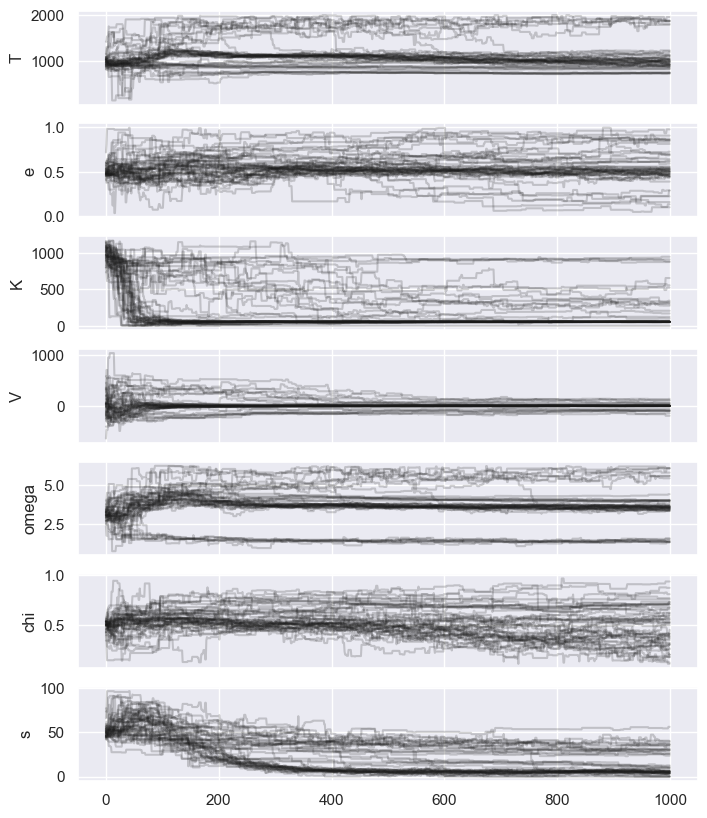

In [9]:
def plot_chains(sampler):
    fig, ax = plt.subplots(7, figsize=(8, 10), sharex=True)
    for i in range(7):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i].set_ylabel(params._fields[i])

plot_chains(sampler)

Yikes! it's all over the place!

The issue here is that our initialization was haphazard and the posterior is extremely multimodal (especially in *T*); given a number of steps approaching infinity, the MCMC algorithm would converge, but we don't have an infinite amount of time to wait! Instead we can more carefully initialize the walkers.

First, let's use a Lomb-Scargle periodogram to find a suitable guess at the period.
The [gatspy](http://www.astroml.org/gatspy/) package has a nice implementation (first you need to ``pip install gatspy``)

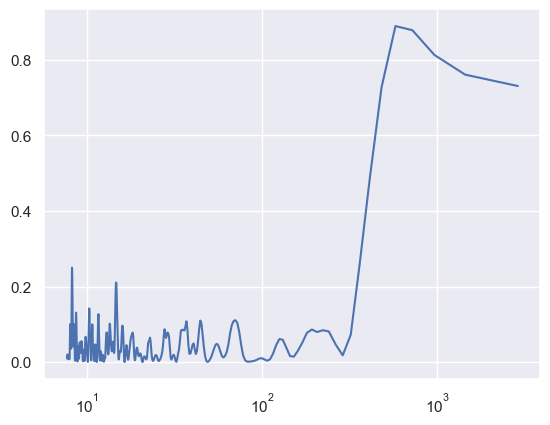

In [16]:
from gatspy.periodic import LombScargleFast
model = LombScargleFast()

model.fit(t_sim, rv_sim, err_sim)
periods, power = model.periodogram_auto()
plt.semilogx(periods, power)
#plt.xlim(0, 10000)

Now we can choose a sensible starting point with this period, and with other parameters estimated from the data

In [17]:
def make_starting_guess(t, rv, rv_err):
    model = LombScargleFast()
    model.optimizer.set(period_range=theta_lim.T, quiet=True)
    model.fit(t, rv, rv_err)

    rv_range = 0.5 * (np.max(rv) - np.min(rv))
    rv_center = np.mean(rv)
    return params(T=model.best_period,
                  e=0.1,
                  K=rv_range,
                  V=rv_center,
                  omega=np.pi,
                  chi=0.5,
                  s=rv_err.mean())

theta_guess = make_starting_guess(t_sim, rv_sim, err_sim)
theta_guess

ValueError: The optimizer is not designed to search for for periods larger than the data baseline. 

In [ ]:
sampler.reset()
start = theta_guess * (1 + 0.01 * rng.randn(nwalkers, ndim))
pos, prob, state = sampler.run_mcmc(start, 1000)

In [ ]:
plot_chains(sampler)

In [18]:
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

In [ ]:
import corner
corner.corner(sampler.flatchain, labels=params._fields, truths=theta_sim);

In [ ]:
rng = np.random.RandomState(42)

rv_fit = [radial_velocity(t_fit, sampler.flatchain[i])
          for i in rng.choice(sampler.flatchain.shape[0], 200)]

plt.errorbar(t_sim, rv_sim, err_sim, fmt='.k')
plt.plot(t_fit, np.transpose(rv_fit), '-k', alpha=0.01)
plt.xlabel('time (days)')
plt.ylabel('radial velocity (km/s)');

In [ ]:
import corner
corner.corner(sampler.flatchain[:, :2], 
              labels=params._fields[:2],
              truths=theta_sim[:2]);